In [34]:
!pip install -U segmentation_models --quiet

In [35]:
import segmentation_models as sm
# you have to delete the "generic_utils" from the file that makes the segmentatin_models import fail:
# from this:  keras.utils.generic_utils.get_custom_objects().update(custom_objects)
# to this:    keras.utils.get_custom_objects().update(custom_objects)
# then: save the file + restart the runtime

In [2]:
# only do this step, if you couldnt find the ACDC.zip in the github folder
# the zipped data folder can be found at:
# https://drive.google.com/file/d/1MYiAgXNCV9E11f92Im_YNJs7TFUs6MBm/view?usp=share_link

import gdown

file_id = '1MYiAgXNCV9E11f92Im_YNJs7TFUs6MBm'
url = f'https://drive.google.com/uc?id={file_id}'
output_file = '/content/ACDC.zip'
gdown.download(url, output_file, quiet=False)

import zipfile
zipfile.ZipFile('/content/ACDC.zip', 'r').extractall('/content')

Downloading...
From: https://drive.google.com/uc?id=1MYiAgXNCV9E11f92Im_YNJs7TFUs6MBm
To: /content/ACDC.zip
100%|██████████| 33.6M/33.6M [00:00<00:00, 64.0MB/s]


'/content/ACDC.zip'

In [4]:
# before running this cell, make sure to have the ACDC folder ready
import tensorflow as tf
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

SIZE_X = 256
SIZE_Y = 256

dataset_folder = f'/content/ACDC/database'
image_files = sorted(os.listdir(f'{dataset_folder}/train'))
mask_files = sorted(os.listdir(f'{dataset_folder}/trainannot'))
train_images = []
train_masks = []

for img_path, mask_path in zip(image_files, mask_files):
    img = cv2.imread(f'{dataset_folder}/train/{img_path}', 1) #change this to 0 to read it in grayscale
    # img = cv2.resize(img, (SIZE_Y, SIZE_X)) #the images were already the appropriate size
    img = img.astype(float) / 255.0
    train_images.append(img)

    mask = cv2.imread(f'{dataset_folder}/trainannot/{mask_path}', 0)
    # mask = cv2.resize(mask, (SIZE_Y, SIZE_X)) #the masks were already the appropriate size
    mask = mask.astype(float)
    train_masks.append(mask)

train_images = np.array(train_images)
train_masks = np.array(train_masks)

X = train_images
# X = np.expand_dims(X, axis=3) #needed, if we read images as grayscale
Y = train_masks
Y = np.expand_dims(Y, axis=3)


In [ ]:
print("Total images in the  dataset: \t", len(train_images))
print("Image data shape is: \t\t", train_images.shape)
# print("Expanded mask data shape is: \t", X.shape)
print("Mask data shape is: \t\t", train_masks.shape)
print("Expanded mask data shape is: \t", Y.shape)
print("Max pixel value in image is: \t", train_images.max())
print("Labels in the mask are : \t", np.unique(train_masks))

Total images in the  dataset: 	 600
Image data shape is: 		 (600, 256, 256, 3)
Mask data shape is: 		 (600, 256, 256)
Expanded mask data shape is: 	 (600, 256, 256, 1)
Max pixel value in image is: 	 1.0
Labels in the mask are : 	 [0. 1. 2. 3.]


random number generaterd:  325


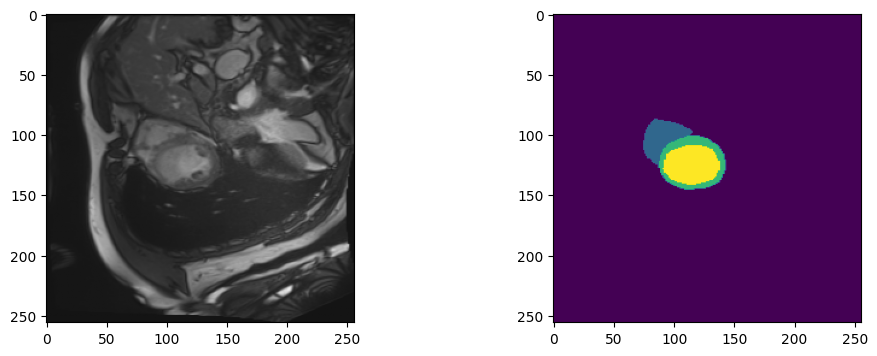

In [ ]:
# sanity check to see if the order of the images is correct
import random

i = random.randint(0, 600)
print("random number generaterd: ", i)
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(X[i])
plt.subplot(122)
plt.imshow(Y[i])

In [ ]:

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import keras

BACKBONE = 'resnet34'
BATCH_SIZE = 8
EPOCHS = 30
LR = 0.0001
n_classes = 4

preprocess_input = sm.get_preprocessing(BACKBONE)


x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

y_train_cat = to_categorical(y_train, num_classes=n_classes).reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))
y_val_cat = to_categorical(y_val, num_classes=n_classes).reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2], n_classes))

print("The inputs are:")
print("\tx_train: \t", x_train.shape)
print("\tx_val: \t\t", x_val.shape)
print("Before converting to categorical data:")
print("\ty_train: \t", y_train.shape)
print("\ty_val: \t\t", y_val.shape)
print("After converting to categorical data:")
print("\ty_train_cat: \t", y_train_cat.shape)
print("\ty_val_cat: \t", y_val_cat.shape)
print("Class values in the dataset: ", np.unique(y_train))
# print("Class values in the dataset: ", np.unique(y_train_cat))
# print("Class values in the dataset: ", np.unique(y_val_cat))

activation = 'softmax'
optim = keras.optimizers.Adam(LR)
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)
loss = total_loss

# loss = sm.losses.DiceLoss(class_indexes=range(1, n_classes + 1))
# loss = sm.losses.JaccardLoss()
# metrics = ['accuracy']

model = sm.Linknet(BACKBONE, encoder_weights='imagenet', activation=activation, classes=n_classes)
# model = sm.Unet(BACKBONE, input_shape=(256, 256, 3), encoder_weights=None, activation=activation, classes=n_classes)

model.compile(optimizer=optim, loss=loss, metrics=metrics)
# model.compile(optimizer='Adam', loss=loss, metrics=metrics)


print(model.summary())


In [ ]:
# it takes about 6 mins to train
history=model.fit(x_train, y_train_cat,
                  batch_size=BATCH_SIZE,
                  epochs=EPOCHS,
                  verbose=1,
                  validation_data=(x_val, y_val_cat))

In [ ]:
history.history

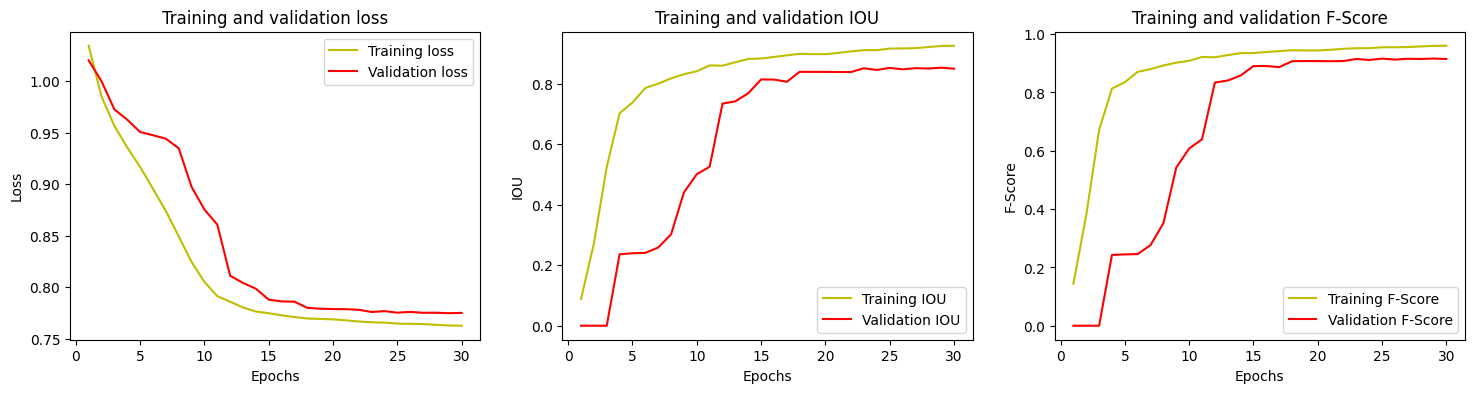

In [32]:
import csv
# generate plots from the acquired metrics of the training
loss, val_loss, acc, val_acc = history.history['loss'], history.history['val_loss'], history.history['iou_score'], history.history['val_iou_score']
fscore, val_fscore = history.history['f1-score'], history.history['val_f1-score']
epochs = range(1, len(loss) + 1)

# Write the training history to a CSV file
with open('training_history_unet.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Loss', 'Val Loss', 'Accuracy', 'Val Accuracy', 'F-Score', 'Val F-Score'])
    writer.writerows(zip(epochs, loss, val_loss, acc, val_acc, fscore, val_fscore))

# Plot the training history
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

axes[0].plot(epochs, loss, 'y', label='Training loss')
axes[0].plot(epochs, val_loss, 'r', label='Validation loss')
axes[1].plot(epochs, acc, 'y', label='Training IOU')
axes[1].plot(epochs, val_acc, 'r', label='Validation IOU')
axes[2].plot(epochs, fscore, 'y', label='Training F-Score')
axes[2].plot(epochs, val_fscore, 'r', label='Validation F-Score')

[ax.set_xlabel('Epochs') for ax in axes] and [ax.legend() for ax in axes]

axes[0].set_title('Training and validation loss')
axes[0].set_ylabel('Loss')
axes[1].set_title('Training and validation IOU')
axes[1].set_ylabel('IOU')
axes[2].set_title('Training and validation F-Score')
axes[2].set_ylabel('F-Score')

plt.savefig('/content/unet_metrics_plot.png')
plt.show()


In [14]:
# you can save the model, if you want
model.save('/content/base_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [33]:
from keras.metrics import MeanIoU, Precision, Recall
import os
import cv2
import numpy as np

model = load_model('/content/base_model.h5', compile=False) # comment out this line, if you didnt save the model in the step before

dataset_folder = '/content/ACDC/database'
image_files = sorted(os.listdir(f'{dataset_folder}/test'))
mask_files = sorted(os.listdir(f'{dataset_folder}/testannot'))

test_images = []
test_masks = []

for img_path, mask_path in zip(image_files, mask_files):
    img = cv2.imread(f'{dataset_folder}/test/{img_path}', 1)
    img = img.astype(float) / 255.0
    test_images.append(img)

    mask = cv2.imread(f'{dataset_folder}/testannot/{mask_path}', 0)
    mask = mask.astype(float)
    test_masks.append(mask)

x_test = np.array(test_images)
y_test = np.expand_dims(np.array(test_masks), axis=3)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
precision = Precision()
recall = Recall()

mean_iou = 0.0
mean_f1 = 0.0

for i in range(len(x_test)):
    test_img = x_test[i]
    test_img_gt = y_test[i]

    test_img_input = np.expand_dims(test_img, 0)
    test_img_pred = np.argmax(model.predict(test_img_input, verbose=0), axis=3)[0, :, :]

    # Calculate IUO (Intersection over Union) and update state
    IOU_keras.update_state(test_img_gt[:, :, 0], test_img_pred)
    mean_iou += IOU_keras.result().numpy()

    # Update state for Precision and Recall
    precision.update_state(test_img_gt[:, :, 0], test_img_pred)
    recall.update_state(test_img_gt[:, :, 0], test_img_pred)

    precision_result = precision.result().numpy()
    recall_result = recall.result().numpy()

    # Calculate F1 score
    f1_score = 2 * (precision_result * recall_result) / (precision_result + recall_result + 1e-10)
    mean_f1 += f1_score

mean_iou /= len(x_test)
mean_f1 /= len(x_test)

print("Mean IoU =", mean_iou)
print("Mean F1 Score =", mean_f1)

# Save results to CSV
import csv

with open('unet_test_results.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Metric', 'Value'])
    writer.writerow(['Mean IoU', mean_iou])
    writer.writerow(['Mean F1 Score', mean_f1])


Mean IoU = 0.8393892039855321
Mean F1 Score = 0.9340872077570664


In [ ]:
# test and compare the predicted image with the ground truth, and save the resulting plot
import random
from keras.models import load_model

img_num = random.randint(0, len(x_val) - 1)

test_img = x_val[img_num]
test_img_gt = y_val[img_num]

test_img_input = np.expand_dims(preprocess_input(test_img), 0)
test_img_pred = np.argmax(model.predict(test_img_input), axis=3)[0,:,:]


plt.figure(figsize=(12, 8))

# First row: Original image, Ground truth label, and Full prediction
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')

plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_img_gt)

plt.subplot(233)
plt.title('Prediction on Test Image')
plt.imshow(test_img_pred)

# Second row: Displaying the segments of the three classes separately
class_segments = [np.where(test_img_pred == i + 1, i + 1, 0) for i in range(3)]
titles = ['Class 1 Segment', 'Class 2 Segment', 'Class 3 Segment']

for i in range(3):
    plt.subplot(2, 3, i + 4)
    plt.title(titles[i])
    plt.imshow(class_segments[i], cmap='gray')

plt.savefig('/content/base_model_prediction_plot.png')
plt.show()
